# Experimentation: Segmenation
---

In [4]:
# Import libraries
import sys
sys.path.append("..")

from monai.config import print_config
from monai.networks.nets import SwinUNETR
from src.preprocessing import get_transforms, get_datasets, get_dataloaders

import torch

# Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# Get transforms
transform = get_transforms()

# Get datasets
train_ds, val_ds = get_datasets(root_dir="../data", collection="HCC-TACE-Seg", transform=transform, download_len=5, val_frac=0.2)

# Get dataloaders
train_loader, val_loader = get_dataloaders(train_ds, val_ds, batch_size=1)

# Check length of datasets and dataloaders
print(train_ds.get_indices(), val_ds.get_indices())
print(len(train_loader), len(val_loader))

2024-03-24 11:36:47,118 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip.
2024-03-24 11:36:47,118 - INFO - File exists: ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.zip, skipped downloading.
2024-03-24 11:36:47,134 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\raw\1.2.276.0.7230010.3.1.3.8323329.41.1604860085.518229.
2024-03-24 11:36:47,644 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip.
2024-03-24 11:36:47,644 - INFO - File exists: ..\data\HCC-TACE-Seg\1.3.6.1.4.1.14519.5.2.1.1706.8374.172517341095680731665822868712.zip, skipped downloading.
2024-03-24 11:36:47,644 - INFO - Writing into directory: ..\data\HCC-TACE-Seg\HCC_017\300\image.
2024-03-24 11:36:47,936 - INFO - Expected md5 is None, skip md5 check for file ..\data\HCC-TACE-Seg\1.2.276.0.7230010.3.1.3.8323329.208

In [6]:
# Create a Swin-UNet model
model = SwinUNETR(img_size=(64, 64, 64), in_channels=1, out_channels=5, use_v2 = True, spatial_dims=3)

In [7]:
# Set the model to use the GPU
model = model.to(device)

# Set the hyperparameters for training
max_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-5
val_interval = 1

# Set the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
loss_function = torch.nn.CrossEntropyLoss()
# Create the training loop

# Set the model to training mode
model.train()

# Iterate over the training data for the specified number of epochs
for epoch in range(max_epochs):
    for batch in train_loader:
        # Extract the image and segmentation from the batch
        image, seg = batch["image"].to(device), batch["seg"].to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(image)
        
        # Compute the loss
        loss = loss_function(output, torch.argmax(seg, dim=1))
        
        # Backward pass
        loss.backward()
        
        # Update the weights
        optimizer.step()
        
    # Print the loss for each epoch
    print(f"Epoch [{epoch+1}/{max_epochs}], Loss: {loss.item():.4f}")
    
    # Set the model to evaluation mode
    model.eval()
    
    # Compute the validation loss
    with torch.no_grad():
        for batch in val_loader:
            image, seg = batch["image"].to(device), batch["seg"].to(device)
            output = model(image)
            loss = loss_function(output, torch.argmax(seg, dim=1))
        print(f"Validation Loss: {loss.item():.4f}")

torch.Size([4, 512, 512, 64])
torch.Size([4, 512, 512, 64])
torch.Size([4, 512, 512, 64])
torch.Size([5, 512, 512, 64])
Epoch [1/10], Loss: 2.3073
torch.Size([4, 512, 512, 64])
Validation Loss: 0.7701
torch.Size([4, 512, 512, 64])
torch.Size([5, 512, 512, 64])
torch.Size([4, 512, 512, 64])
torch.Size([4, 512, 512, 64])
Epoch [2/10], Loss: 0.7008
torch.Size([4, 512, 512, 64])
Validation Loss: 0.7515
torch.Size([4, 512, 512, 64])
torch.Size([4, 512, 512, 64])
torch.Size([4, 512, 512, 64])
torch.Size([5, 512, 512, 64])
Epoch [3/10], Loss: 2.0693
torch.Size([4, 512, 512, 64])
Validation Loss: 0.6779
torch.Size([5, 512, 512, 64])
torch.Size([4, 512, 512, 64])
torch.Size([4, 512, 512, 64])
torch.Size([4, 512, 512, 64])
Epoch [4/10], Loss: 0.6345
torch.Size([4, 512, 512, 64])
Validation Loss: 0.6677
torch.Size([4, 512, 512, 64])
torch.Size([4, 512, 512, 64])
torch.Size([5, 512, 512, 64])
torch.Size([4, 512, 512, 64])
Epoch [5/10], Loss: 0.6399
torch.Size([4, 512, 512, 64])
Validation Loss: 0.

In [8]:
# Save the model
torch.save(model.state_dict(), "../models/swin_unetr.pth")

torch.Size([4, 512, 512, 64])
torch.Size([1, 1, 64, 64, 64]) torch.Size([1, 4, 64, 64, 64]) torch.Size([1, 5, 64, 64, 64])
metatensor([[[[[-2.1997, -1.9808, -1.9119,  ..., -1.9413, -2.2910, -2.4056],
           [-2.0087, -2.0557, -2.1375,  ..., -2.1438, -2.2597, -2.3404],
           [-2.1395, -2.1275, -2.3523,  ..., -2.2979, -2.4882, -2.3193],
           ...,
           [-2.0570, -2.1665, -2.2951,  ..., -2.3288, -2.3676, -2.3633],
           [-2.2577, -2.2311, -2.4710,  ..., -2.3916, -2.4564, -2.2369],
           [-2.4547, -2.1904, -2.4641,  ..., -2.4991, -2.3515, -2.6346]],

          [[-2.3973, -2.1704, -2.0741,  ..., -2.1834, -2.4341, -2.1842],
           [-2.3303, -2.3809, -2.1731,  ..., -2.2227, -2.5272, -2.2556],
           [-2.5185, -2.7545, -2.4914,  ..., -2.5894, -2.7436, -2.3344],
           ...,
           [-2.5314, -2.7191, -2.5636,  ..., -2.5343, -2.7730, -2.2722],
           [-2.4861, -2.8701, -2.5994,  ..., -2.6810, -2.6198, -2.4779],
           [-2.8054, -2.7122, -2.795

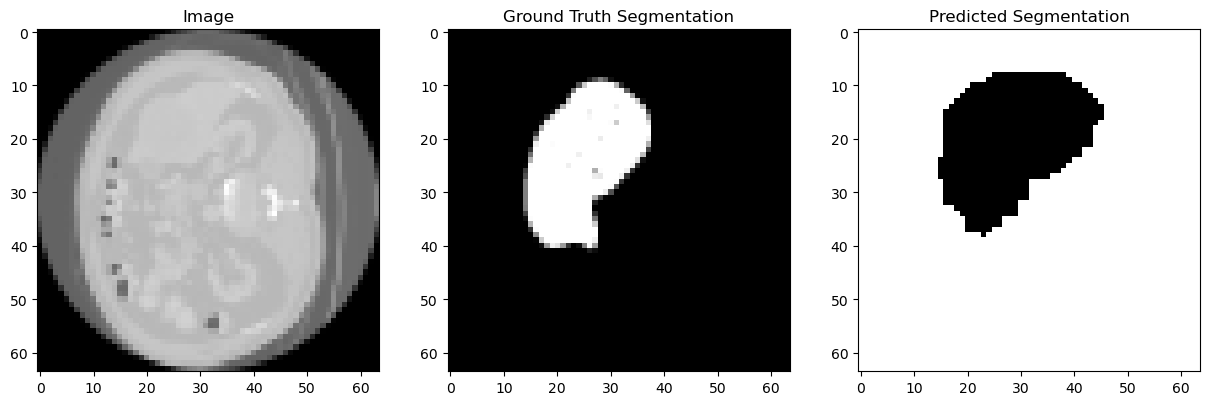

In [21]:

# TODO: Saving a CT volume tensor to image format (DICOM / NIFTI)

# Load the model
model.load_state_dict(torch.load("../models/swin_unetr.pth"))

# Set the model to evaluation mode
model.eval()

# Sample a batch of data from the test dataloader to make predictions
batch = next(iter(val_loader))

# Extract the image and segmentation from the batch
image, seg = batch["image"].to(device), batch["seg"].to(device)

# Make predictions on the image
output = model(image)

# Get the predicted segmentation class for each pixel
pred_seg = output


# Visualize the image, ground truth segmentation, and predicted segmentation
import matplotlib.pyplot as plt
import numpy as np

slice_idx = 50

print(image.shape, seg.shape, pred_seg.shape)
print(pred_seg)
pred_seg = torch.argmax(pred_seg, dim=1).unsqueeze(1)

# Convert the image, ground truth segmentation, and predicted segmentation to NumPy arrays
image = image.cpu().detach().numpy()
seg = seg.cpu().detach().numpy()
pred_seg = pred_seg.cpu().detach().numpy()

# Get the first image, ground truth segmentation, and predicted segmentation from the batch
image = image[0, 1, :, :, slice_idx]
seg = seg[0, 1, :, :, slice_idx]
pred_seg = pred_seg[0, 1, :, :, slice_idx]

# Plot the image, ground truth segmentation, and predicted segmentation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap="gray")
axes[0].set_title("Image")
axes[1].imshow(seg, cmap="gray")
axes[1].set_title("Ground Truth Segmentation")
axes[2].imshow(pred_seg, cmap="gray")
axes[2].set_title("Predicted Segmentation")
plt.show()

